# Lab 2: Cats vs Dogs

**Deadline**: Feb 01, 5:00pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**Marking TA**: Tinglin (Francis) Duan

This lab is partially based on an assignment developed by Prof. Jonathan Rose and Harris Chan.

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1iDiNPHyq0gmdb2wzeaa1S73US29Ky7QI?usp=sharing

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

Files already downloaded and verified
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

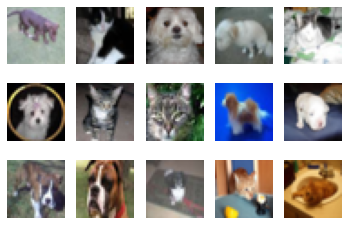

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [ ]:
print("How many training examples do we have for the combined cat and dog classes?")
print("   " + str(len(train_loader)))

print("How many validation examples do we have for the combined cat and dog classes?")
print("   " + str(len(val_loader)))

print("How many training examples do we have for the combined cat and dog classes?")
print("   " + str(len(test_loader)))

How many training examples do we have for the combined cat and dog classes?
   8000
How many validation examples do we have for the combined cat and dog classes?
   2000
How many training examples do we have for the combined cat and dog classes?
   2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

Answer:

The validation set is used for testing models accuracy, parameter selection and to avoild overfitting.

The reason that we need a validation set when traning out model is to make the model be more accurate. Since the testing datasets are for the final testing and should be used only when the model has been finished implemented, we should not use them while traning. 

If we use the training set, since we create the model by using them, if we want to make desicions about hyperparameters or track the accuracy, it will get overfit. The result will not be subjective to the adjustment and validation. 

So, it is necessaty to provide another set of validation datas when training out model.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
print("Small_net parameters:")
for param in small_net.parameters():
    print(param.shape)
print("\nLarge_net parameters:")
for param in large_net.parameters():
    print(param.shape)


Small_net parameters:
torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])

Large_net parameters:
torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])


Answer:

Total # of parameters in small_net = 5*3*3*3 + 5 + 1*245 + 1 = 386

Total # of parameters in large_net = 5*3*5*5 + 5 + 10*5*5*5 + 10 + 32*250 + 32 + 1*32 + 1 = 9705

### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

Answer:

The default values of the parameters `batch_size`, `learning_rate`, and `num_epochs` are `64`, `0.01` and `30`, respectively.


### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [ ]:
train_net(small_net, num_epochs=5) #call train_net with small_net, and train for 5 epochs

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.429125, Train loss: 0.6759076609611511 |Validation err: 0.3775, Validation loss: 0.6534486319869757
Epoch 2: Train err: 0.361, Train loss: 0.6403536524772644 |Validation err: 0.3775, Validation loss: 0.6540046762675047
Epoch 3: Train err: 0.334625, Train loss: 0.6169258975982665 |Validation err: 0.336, Validation loss: 0.6135102435946465
Epoch 4: Train err: 0.318875, Train loss: 0.5990912899971008 |Validation err: 0.3485, Validation loss: 0.6191740091890097
Epoch 5: Train err: 0.309875, Train loss: 0.5884846107959747 |Validation err: 0.3285, Validation loss: 0.6017458196729422
Finished Training
Total time elapsed: 19.58 seconds


Answer:

Based on the following code, there exists five checkpoints that it saves the current model to a file.

` model_path = get_model_name(net.name, batch_size, learning_rate, epoch)`
` torch.save(net.state_dict(), model_path)`

Since we are calling the small_net and no change with the batch_Size and learning_rate, the five file saving process will be:

1. Model: small_net, Batch_size: 64, Learning_rate: 0.01, Epoch: 0
2. Model: small_net, Batch_size: 64, Learning_rate: 0.01, Epoch: 1
3. Model: small_net, Batch_size: 64, Learning_rate: 0.01, Epoch: 2
4. Model: small_net, Batch_size: 64, Learning_rate: 0.01, Epoch: 3
5. Model: small_net, Batch_size: 64, Learning_rate: 0.01, Epoch: 4

Based on the following code, there exists four times of saving files to CSV type for the train/test loss/err values.

` epochs = np.arange(1, num_epochs + 1)` 

` np.savetxt("{}_train_err.csv".format(model_path), train_err)` 

` np.savetxt("{}_train_loss.csv".format(model_path), train_loss)` 

` np.savetxt("{}_val_err.csv".format(model_path), val_err)` 

` np.savetxt("{}_val_loss.csv".format(model_path), val_loss)` 

Since the code is outside the epoch for loop, it saved the train_err, train_loss, val_err and val_loss datas seperatly with four times in total.

1. Model: small_net, Batch_size: 64, Learning_rate: 0.01, Epoch: 4, CSV file content: train_error
2. Model: small_net, Batch_size: 64, Learning_rate: 0.01, Epoch: 4, CSV file content: train_loss
3. Model: small_net, Batch_size: 64, Learning_rate: 0.01, Epoch: 4, CSV file content: val_err
4. Model: small_net, Batch_size: 64, Learning_rate: 0.01, Epoch: 4, CSV file content: val_loss



### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Train both small_net and large_net using the function train_net and its default parameters
print("------------------------------------------------training for small_net")
train_net(small_net)

print("\n------------------------------------------------training for large_net")
train_net(large_net)

------------------------------------------------training for small_net
Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.426375, Train loss: 0.6762333779335022 |Validation err: 0.369, Validation loss: 0.6512321196496487
Epoch 2: Train err: 0.354875, Train loss: 0.6383493151664734 |Validation err: 0.3645, Validation loss: 0.6542029641568661
Epoch 3: Train err: 0.3395, Train loss: 0.6214949712753296 |Validation err: 0.35, Validation loss: 0.6223773881793022
Epoch 4: Train err: 0.3315, Train loss: 0.6070578649044037 |Validation err: 0.3495, Validation loss: 0.6307939775288105
Epoch 5: Train err: 0.320625, Train loss: 0.5986896252632141 |Validation err: 0.3315, Validation loss: 0.6189757902175188
Epoch 6: Train err: 0.30975, Train loss: 0.5889757220745087 |Validation err: 0.324, Validation loss: 0.6137909144163132
Epoch 7: Train err: 0.30975, Train loss: 0.5846510627269745 |Validation err: 0.332, Validation loss: 0.6105258176103234
Epoch 8: T

Answer:

According to the output above, the training time elapsed for `small_net` process and `large_net` process are `98.00 seconds` and `106.67 seconds`, respectively.

The `large_net` network takes more time, because it contains more parameters that the `small_net` network and it takes more time to modeling the training process.

I need to state that, the first time I run the test cases, the output are 98.00 seconds and 106.67 seconds. I kept this two number for comparison for the following part in part2 and part3. However, after I rerun the code as preperation for the later parts (4&5) the other day. The time elapsed has changed to 115.75 seconds and 128.97 seconds. Each time I ran, it has small variations. But, overall, the large_net network will take more time than the small_net network.

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

------------------------------------------------output curve for small_net


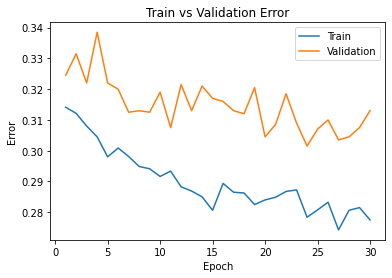

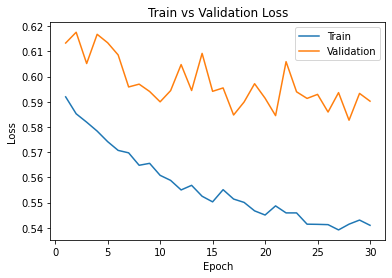


------------------------------------------------output curve for large_net


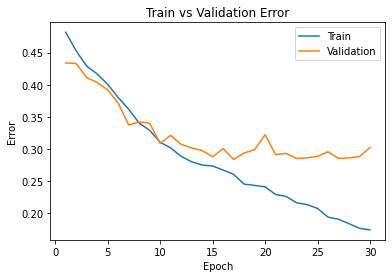

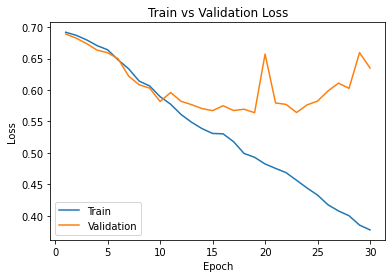

In [ ]:
print("------------------------------------------------output curve for small_net")
small_model_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(small_model_path)

print("\n------------------------------------------------output curve for large_net")
large_model_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(large_model_path)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

Accoding to the lecture, overfitting occurs when training data performs well but validation data performs poorly. Underfitting is when the model is not complex enough for all relationsips for inputs and labels, so it has high biased. 

As we noticed from the small_net network, the general trends as the epoch number increases, the training and validation datas decreases are similar. The difference between error/loss of the training and validataion datas are not large.

For the large_net network, we realized that at the begining the loss and error values are significance, which implies that the model is underfitting. After more epoch iterations had occured, the training datasets reached a very low erroness and loss, but leads to a very high or even higher validation erroness. So, it turns out to have a sign of overfitting, which is differ from the small_net network in the general trends.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360018730163 |Validation err: 0.467, Validation loss: 0.6924686655402184
Epoch 2: Train err: 0.448625, Train loss: 0.692258969783783 |Validation err: 0.4305, Validation loss: 0.691649341955781
Epoch 3: Train err: 0.43575, Train loss: 0.6916067352294922 |Validation err: 0.4285, Validation loss: 0.6908544301986694
Epoch 4: Train err: 0.43, Train loss: 0.6908614501953125 |Validation err: 0.4245, Validation loss: 0.6896599512547255
Epoch 5: Train err: 0.434375, Train loss: 0.6899197044372558 |Validation err: 0.4195, Validation loss: 0.6886946316808462
Epoch 6: Train err: 0.435875, Train loss: 0.6887416214942932 |Validation err: 0.4195, Validation loss: 0.6867832522839308
Epoch 7: Train err: 0.436875, Train loss: 0.687377580165863 |Validation err: 0.418, Validation loss: 0.6851987168192863
Epoch 8: Train err: 0.4375, Train loss: 0.6859274730682373 |Validation err: 0.411

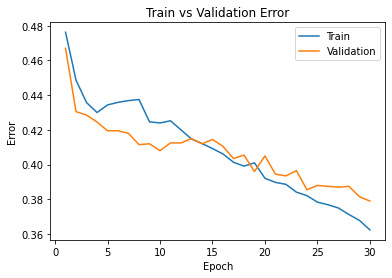

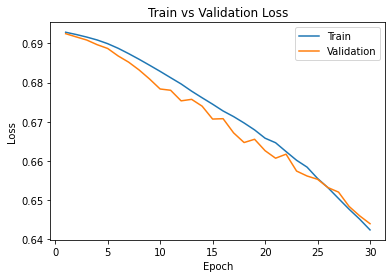

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, 64, 0.001, 30) #Train large_net with all default parameters, except set learning_rate=0.001

print("\n------------------------------------------------output curve for large_net")
large_model_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(large_model_path)

Answer:

With `learning_rate = 0.001`, it takes `106.52 seconds`. With `learning_rate = 0.01`, it takes `106.67 seconds`. These two testcases roughly takes the same time for modeling.

----------

We noticed by anaylysing the graph, by lowering the learning_rate, the training and validation value are roughly have similar values, which represents it can avoid overfiting compares to the previous diagram with smaller step size for the weights updated during the training process. 

Also, for the previous error/loss diagram, when epoch closer to 29 and learning rate = 0.01, the error/loss value are nearly 0.15 and 0.3. However, in this case, when epoch closer to 29 and learning rate = 0.001, the error/loss value are significantly higher than 0.36 and 0.64. The errorness and loss increased to be higher than before, which means 0.001 is still not be the best case as when updating the weights, the step size is too small, so it is too slow within the 30 epoches to reach a very good model/weights. According to lecture notes, for smaller learning rates, parameters don’t change very much in each iteration and it will take a long time to train the network.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.426875, Train loss: 0.6743021264076233 |Validation err: 0.373, Validation loss: 0.6364669129252434
Epoch 2: Train err: 0.367125, Train loss: 0.6398710680007934 |Validation err: 0.3755, Validation loss: 0.6349833384156227
Epoch 3: Train err: 0.358125, Train loss: 0.629592146396637 |Validation err: 0.348, Validation loss: 0.6240996662527323
Epoch 4: Train err: 0.343125, Train loss: 0.6167744815349578 |Validation err: 0.3405, Validation loss: 0.6115005295723677
Epoch 5: Train err: 0.3315, Train loss: 0.5990285336971283 |Validation err: 0.348, Validation loss: 0.6214024610817432
Epoch 6: Train err: 0.31125, Train loss: 0.5800493450164795 |Validation err: 0.3195, Validation loss: 0.6157716857269406
Epoch 7: Train err: 0.31025, Train loss: 0.5827681159973145 |Validation err: 0.3625, Validation loss: 0.6364191770553589
Epoch 8: Train err: 0.305375, Train loss: 0.5704554648399353 |Validation err: 

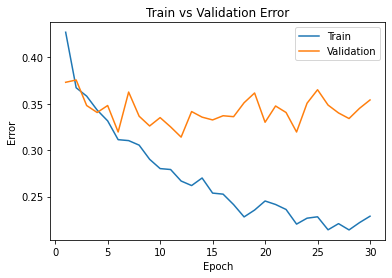

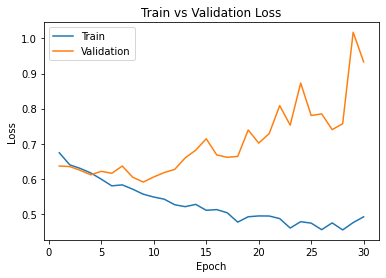

In [ ]:
large_net = LargeNet()
train_net(large_net, 64, 0.1, 30) #Train large_net with all default parameters, except set learning_rate=0.1

print("\n------------------------------------------------output curve for large_net")
large_model_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(large_model_path)

Answer:

With `learning_rate = 0.1`, it takes `106.71 seconds`. With `learning_rate = 0.01`, it takes `106.67 seconds`. These two testcases roughly takes the same time for modeling.

----------------

We noticed by anaylysing the graph, by increasing the learning_rate, the training and validation value have larger seperation for the trends, which represents it cannot avoid overfiting and enlarged the overfiting issue compares to the previous diagram, with larger step size for the weights updated during the training process. 

Also, for the previous error/loss diagram, when epoch closer to 29 and learning rate = 0.01, the error/loss value are nearly 0.15 and 0.3. However, in this case, when epoch closer to 29 and learning rate = 0.1, the error/loss value are significantly higher than 0.36 and 0.9. The errorness and loss increased to be higher than before, especially for vaidation datasets, although the training datasets has a lower loss/err value. It means 0.1 is still not be the best case as when updating the weights, the step size is too big, it is too fast within the 30 epoches and enlarge the overfitting of the model. Acording to the lecture notes, large learning rate has large step size that can be detrimental to neural network training.

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379515349865 |Validation err: 0.478, Validation loss: 0.6926823854446411
Epoch 2: Train err: 0.457625, Train loss: 0.6924103982746601 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500590741634 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449940383434 |Validation err: 0.424, Validation loss: 0.6897870451211929
Epoch 5: Train err: 0.434, Train loss: 0.6896935552358627 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.6883532032370567 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871826350689 |Validation err: 0.426, Validation loss: 0.6836968809366226
Epoch 8: Train err: 0.43525, Train loss: 0.6849770694971085 |Validation err: 0.411, Va

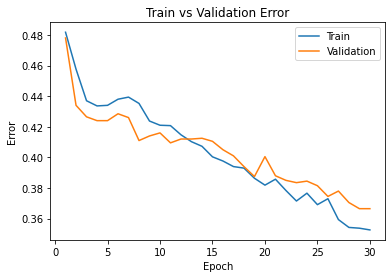

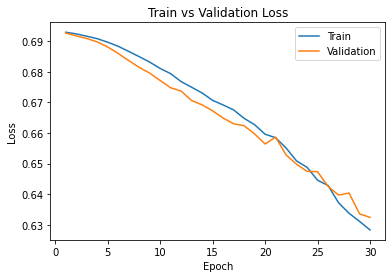

In [ ]:
large_net = LargeNet()
train_net(large_net, 512, 0.01, 30) #Now, set batch_size=512

print("\n------------------------------------------------output curve for large_net")
large_model_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(large_model_path)

Answer:

With `batch_size = 512`, it takes `93.42 seconds` . With `batch_size = 64`, it takes `106.67 seconds`. With higher batch_size, the network takes less time to complete modeling.

As batch_size is representing the number of smaples per batch. So, if by increasing the batch_size, which means that the number of samples per batch will increased and the number of batches itself decreases. So, it will take less time for each iterations and leads to a overall less time.



------------


We noticed by anaylysing the graph, by increasing the batch_size, the training and validation value lines are roughly have similar values, which represents it can avoid overfiting compares to the previous diagram.

Also, for the previous error/loss diagram, when epoch closer to 29 and batch_size = 64, the error/loss value are nearly 0.15 and 0.3. However, in this case, when epoch closer to 29 and batch_size = 512, the error/loss value are significantly higher than 0.36 and 0.63. The errorness and loss increased to be higher than before, as larger in batch_size represents for the larger amount of samples that has been calculated each iteration for the gradient and direction, which leads to the incorrectness. Acording to the lecture notes, since average loss might not change very much as batch size grows, so larger batch size is too precise as it limits the "noise" occur in the iteration and let the training converge slower.

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.432, Train loss: 0.6775538735389709 |Validation err: 0.379, Validation loss: 0.6519261674880982
Epoch 2: Train err: 0.366375, Train loss: 0.6400574240684509 |Validation err: 0.3595, Validation loss: 0.6199915554523469
Epoch 3: Train err: 0.34225, Train loss: 0.6116521078348159 |Validation err: 0.3425, Validation loss: 0.636887101650238
Epoch 4: Train err: 0.313375, Train loss: 0.5852544190883636 |Validation err: 0.3305, Validation loss: 0.597065006017685
Epoch 5: Train err: 0.302875, Train loss: 0.5665943766832352 |Validation err: 0.3035, Validation loss: 0.5730490152835845
Epoch 6: Train err: 0.279375, Train loss: 0.5459038650989533 |Validation err: 0.3055, Validation loss: 0.5840759282112121
Epoch 7: Train err: 0.271875, Train loss: 0.5282641857862472 |Validation err: 0.308, Validation loss: 0.590907118320465
Epoch 8: Train err: 0.259875, Train loss: 0.5090295715034008 |Validation err: 0

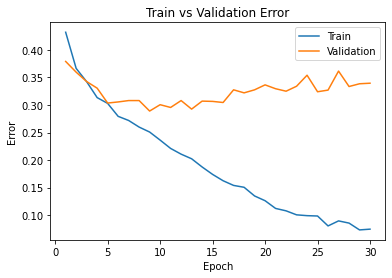

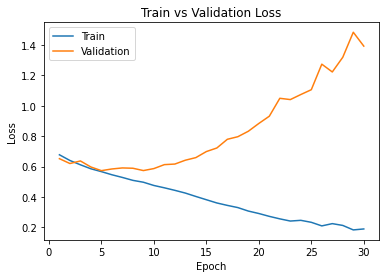

In [ ]:
large_net = LargeNet()
train_net(large_net, 16, 0.01, 30) #Now, set batch_size=16

print("\n------------------------------------------------output curve for large_net")
large_model_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(large_model_path)


Answer:

With `batch_size = 16`, it takes `162.99 seconds` . With `batch_size = 64`, it takes `106.67 seconds`. With lower batch_size, the network takes more time to complete modeling.

As batch_size is representing the number of smaples per batch. So, if by decreasing the batch_size, which means that the number of samples per batch will decreased and the number of batches itself increases. So, it will take more time for each iterations and leads to a overall increasing of time.

----------

We noticed by anaylysing the graph, by decreasing the batch_size, the training and validation value have larger seperation for the trends, which represents it cannot avoid overfiting and enlarged the overfiting issue compares to the previous diagram.

Also, for the previous error/loss diagram, when epoch closer to 29 and batch_size = 64, the error/loss value are nearly 0.15 and 0.3. However, in this case, when epoch closer to 29 and batch_size = 512, the error/loss value are significantly higher than 0.3 and 1.4. Especially for the validation datasets lost, it has a significant loss, although the training sets has a lower err/loss value. Smaller amount of samples that has been calculated each iteration for the gradient and direction, which leads to the incorrectness for to precies to each training sample sets. According to the lecture notes, we optimize a different function loss at each iteration which leads to the trends to be too noisy and leads to the overfitting to the training sets and errorness for the validation sets.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

Answer:

From the comparison of the large network and small network from part two, we find out, the the large network have a better error/loss value and initialy does not have the overfitting issue. So, it is more managable and better network to be chosen.

From the adjustment on batch_size from part3, we noticed that, generally, we should avoid to use too small batch_size, since the gradients that caluclated are based on small portion of the samples, which is not generalized for the model and leads to the overfitting issue. By increasing the batch_size, the overfitting issue will be solved. However, we should not increased it to a number that is too large, which will increase the overall loss/error values. 

In the previous trials, the original trial is `batch_size = 64`, and we increased to `batch_size = 512`, which is too large. So, we can try to increase the batch_size to `batch_size = 128`, which is not that large number and try to see the result.

In conclusion, the set of values for the hyperparameters(network, batch_size, learning_rate) that I think would help me improve the validation accuracy is `network = large_net`, `batch_size = 128`, `learning_rate = 0.01`.



### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.454375, Train loss: 0.6920222299439567 |Validation err: 0.426, Validation loss: 0.6897575631737709
Epoch 2: Train err: 0.44475, Train loss: 0.6877915528085496 |Validation err: 0.411, Validation loss: 0.6820644438266754
Epoch 3: Train err: 0.422125, Train loss: 0.681226979172419 |Validation err: 0.413, Validation loss: 0.6738783977925777
Epoch 4: Train err: 0.410375, Train loss: 0.6737948031652541 |Validation err: 0.408, Validation loss: 0.6660139746963978
Epoch 5: Train err: 0.39725, Train loss: 0.6661599912340679 |Validation err: 0.401, Validation loss: 0.6590253487229347
Epoch 6: Train err: 0.376875, Train loss: 0.6567276139107961 |Validation err: 0.389, Validation loss: 0.6513239853084087
Epoch 7: Train err: 0.374625, Train loss: 0.6488056731602502 |Validation err: 0.376, Validation loss: 0.6396529972553253
Epoch 8: Train err: 0.359875, Train loss: 0.636491524794745 |Validation err: 0.3

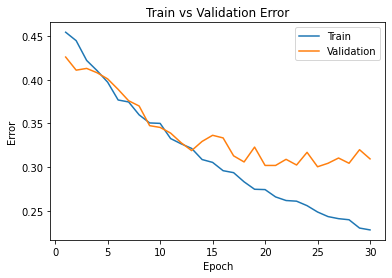

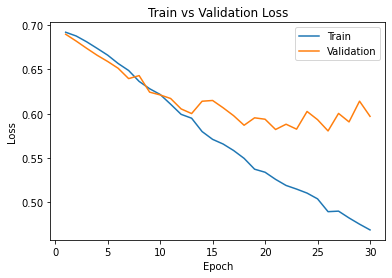

In [ ]:
large_net = LargeNet()
train_net(large_net, 128, 0.01, 30) #Now, set batch_size=128

print("\n------------------------------------------------output curve for large_net")
large_model_path = get_model_name("large", batch_size=128, learning_rate=0.01, epoch=29)
plot_training_curve(large_model_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

Answer:

Additional to the analysis in part a), we can also make some adjustment towards the learning_rate and epoch_size. 

From the adjustment on learning_rate from part3, we noticed that, generally, we should avoid the learning rate to be very large, since the step size when updating the weights each time is too large, which is not generalized for the model and leads to the overfitting issue. By decreasing the learning_rate, the overfitting issue will be solved. However, we should not decreased it to a number that is too small, which will increase the overall loss/error values.
In the previous trials, the original trial is `learning_rate = 0.01` and we decreqased it to `learning_rate = 0.001`, which is too small. So, we can try to decrease the learning_rate to `learning_rate = 0.005`, which is not that small number and try to see the result.

In conclusion, the set of values for the hyperparameters(network, batch_size, learning_rate) that I think would help me improve the validation accuracy is `network = large_net`, `batch_size = 128`, `learning_rate = 0.005`.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.466625, Train loss: 0.6925613236805749 |Validation err: 0.4305, Validation loss: 0.6916250362992287
Epoch 2: Train err: 0.45025, Train loss: 0.6910346017943488 |Validation err: 0.4295, Validation loss: 0.6889704614877701
Epoch 3: Train err: 0.4305, Train loss: 0.6885886050405956 |Validation err: 0.4165, Validation loss: 0.6850010603666306
Epoch 4: Train err: 0.430625, Train loss: 0.6850024423901997 |Validation err: 0.4125, Validation loss: 0.6797147057950497
Epoch 5: Train err: 0.420875, Train loss: 0.6813881851377941 |Validation err: 0.411, Validation loss: 0.6762721762061119
Epoch 6: Train err: 0.415875, Train loss: 0.6773001438095456 |Validation err: 0.4125, Validation loss: 0.672969501465559
Epoch 7: Train err: 0.405, Train loss: 0.6732292080682422 |Validation err: 0.4055, Validation loss: 0.6696001030504704
Epoch 8: Train err: 0.4, Train loss: 0.6694153556748043 |Validation err: 0.402

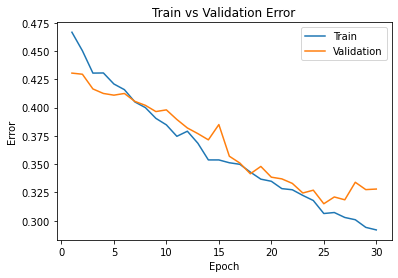

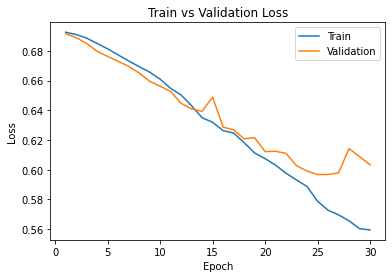

In [ ]:
large_net = LargeNet()
train_net(large_net, 128, 0.005, 30) #Now, set batch_size=128, learning_rate = 0.005

print("\n------------------------------------------------output curve for large_net")
large_model_path = get_model_name("large", batch_size=128, learning_rate=0.005, epoch=29)
plot_training_curve(large_model_path)

## Part 5. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

Answer:

Based on the graph in part 4 b), as epoch_number = 26, the diagram reached a quite low error/loss value. So, we decreased the epoch_number to 26 to avoid the large variation from 26 to 30.

In conclusion, the best model that I can provide so far is: `network = large_net`, `batch_size = 128`, `learning_rate = 0.01` and `epoch_number = 26`.

In [ ]:
net = LargeNet()
train_net(net, 128, 0.01, 26)
model_path = get_model_name(net.name, batch_size=128, learning_rate=0.01, epoch=25)
state = torch.load(model_path)
net.load_state_dict(state)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.454375, Train loss: 0.6920222299439567 |Validation err: 0.426, Validation loss: 0.6897575631737709
Epoch 2: Train err: 0.44475, Train loss: 0.6877915528085496 |Validation err: 0.411, Validation loss: 0.6820644438266754
Epoch 3: Train err: 0.422125, Train loss: 0.681226979172419 |Validation err: 0.413, Validation loss: 0.6738783977925777
Epoch 4: Train err: 0.410375, Train loss: 0.6737948031652541 |Validation err: 0.408, Validation loss: 0.6660139746963978
Epoch 5: Train err: 0.39725, Train loss: 0.6661599912340679 |Validation err: 0.401, Validation loss: 0.6590253487229347
Epoch 6: Train err: 0.376875, Train loss: 0.6567276139107961 |Validation err: 0.389, Validation loss: 0.6513239853084087
Epoch 7: Train err: 0.374625, Train loss: 0.6488056731602502 |Validation err: 0.376, Validation loss: 0.6396529972553253
Epoch 8: Train err: 0.359875, Train loss: 0.636491524794745 |Validation err: 0.3

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

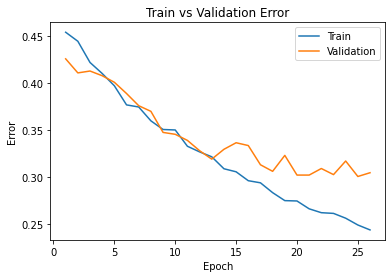

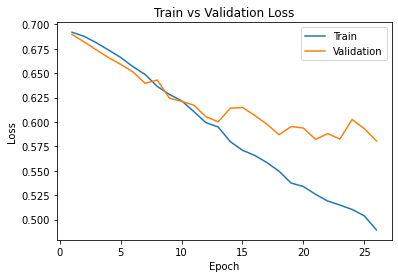

In [ ]:
plot_training_curve(model_path)

Answer:


As we can see from the final output for loss/error values are for our model `net_name=large_net, batch_size=128, learning_rate=0.01, epoch=26` is `Validation err: 0.3045, Validation loss: 0.5805531851947308` which is lower in err/loss than the default training values `net_name=large_net, batch_size=64, learning_rate=0.01, epoch=30`, which is `Validation err: 0.317, Validation loss: 0.7528756745159626`. 

Both the error/loss value and the trace of the diagram from smaller epoch to larger epoch is better than the default one. Since, by increasing the batch_size and decreasing the learning rate, the overfitting of the model has been improved. So, the model for part a will have an overall better proformance than the default one, as the trend of validation error is slightly higher than the training error.


### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=128)

cirterion = nn.BCEWithLogitsLoss()
train_err, train_loss = evaluate(net, train_loader, cirterion)
val_err, val_loss = evaluate(net, val_loader, cirterion)
test_err, test_loss = evaluate(net, test_loader, cirterion)

print("training: err = " + str(train_err) + " / loss = "+ str(train_loss))
print("validation: err = " + str(val_err) + " / loss = "+ str(val_loss))
print("testing: err = " + str(test_err) + " / loss = "+ str(test_loss))


Files already downloaded and verified
Files already downloaded and verified
training: err = 0.2345 / loss = 0.47904046518462046
validation: err = 0.3045 / loss = 0.5845830701291561
testing: err = 0.29 / loss = 0.5610999148339033


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

Answer:

As we can see from the output in part c, the error value for testing is smaller than the error valus for validation. 

-----------
However, we should expect the test error to be higher than the validation error. Because the reason that there is a set of data for validation is to adjust the hyperparameters, to improve the model to reach a good fit, as we use the training datas to build up and train the model, and testing data to test the result. So, as we already used the validation set while adjusting the model towards a good way, so the error will be expected to be less than a group of data that has not been seen for testing. But there exist some exceptions is that, if the data sets is not randomized enough and the testing images is more similar to the training sets, the error of the testing dataset will be lower than fully randomized situation. 




### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

The reason why we should use the test data set at the very end for testing the model for overall performance is that, as the testing data sets are nevered used in training or adjusing hyperparameters. So, compares to other datasets that has contributes to the overall building of the model, the testing dataset is unbiased and is good for the overall testing for the performance at the very end, when the model is complished. 

----

The reason why it is important that we use the test data as little as possible is that, as we evaluate the model each time, the data input and labels will affect the model. So, if we used the test data too many times, the testing data will be less unbiased, and even become biased in the end. If the testing dataset becomes biased, then the error/loss after the evaluation is not valuable for us to see the overall performance of the model.

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.41775, Train loss: 0.668205031326839 |Validation err: 0.399, Validation loss: 0.6558435969054699
Epoch 2: Train err: 0.371125, Train loss: 0.6407988799942864 |Validation err: 0.39, Validation loss: 0.6511164344847202
Epoch 3: Train err: 0.355375, Train loss: 0.628787152350895 |Validation err: 0.383, Validation loss: 0.645381610840559
Epoch 4: Train err: 0.345, Train loss: 0.6168104429093618 |Validation err: 0.399, Validation loss: 0.6566037982702255
Epoch 5: Train err: 0.333125, Train loss: 0.6075799654400538 |Validation err: 0.392, Validation loss: 0.6480461545288563
Epoch 6: Train err: 0.32125, Train loss: 0.597667814247192 |Validation err: 0.383, Validation loss: 0.6525003537535667
Epoch 7: Train err: 0.31075, Train loss: 0.5869401277057709 |Validation err: 0.3715, Validation loss: 0.649830024689436
Epoch 8: Train err: 0.29775, Train loss: 0.5727507538265653 |Validation err: 0.372, Vali

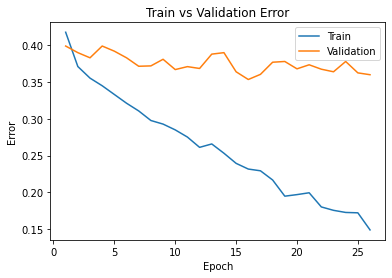

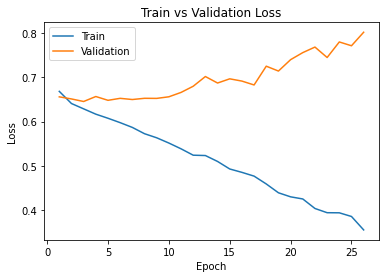

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.40675, Train loss: 0.6628824081420899 |Validation err: 0.383, Validation loss: 0.6505479384213686
Epoch 2: Train err: 0.374, Train loss: 0.6387409133911133 |Validation err: 0.394, Validation loss: 0.6582276318222284
Epoch 3: Train err: 0.3595, Train loss: 0.6286095876693726 |Validation err: 0.379, Validation loss: 0.6436176169663668
Epoch 4: Train err: 0.34775, Train loss: 0.6167842669486999 |Validation err: 0.4055, Validation loss: 0.6707729957997799
Epoch 5: Train err: 0.333125, Train loss: 0.6061416540145874 |Validation err: 0.3765, Validation loss: 0.6455826908349991
Epoch 6: Train err: 0.314, Train loss: 0.5921389698982239 |Validation err: 0.3795, Validation loss: 0.6513363718986511
Epoch 7: Train err: 0.30875, Train loss: 0.5826152532100678 |Validation err: 0.379, Validation loss: 0.6588644441217184
Epoch 8: Train err: 0.289875, Train loss: 0.5654429728984833 |Validation err: 0.3615,

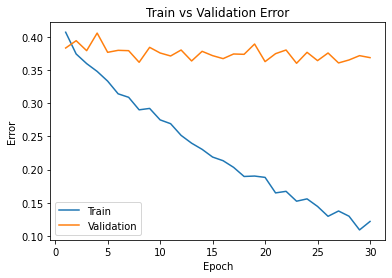

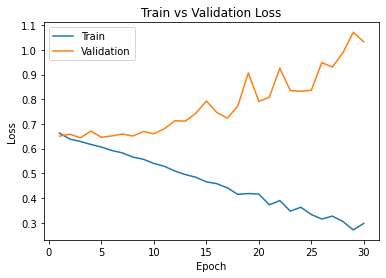

In [ ]:
# copied and modified the code from lab 1 to classifying cat and dog images

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim

torch.manual_seed(1) # set the random seed

# define a 2-layer artificial neural network
class Pigeon(nn.Module):
    def __init__(self):
        super(Pigeon, self).__init__()
        self.layer1 = nn.Linear(3*32*32, 30) #image size 32*32, RGB is 3
        self.layer2 = nn.Linear(30, 1)
        self.name = "pigeon for ANN"
    def forward(self, img):
        flattened = img.view(-1, 3*32*32)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        return activation2.squeeze(1)

pigeon = Pigeon()
train_net(pigeon, 128, 0.01, 26)
ANN_model_path = get_model_name("pigeon for ANN", batch_size=128, learning_rate=0.01, epoch=25)
plot_training_curve(ANN_model_path)

pigeon1 = Pigeon()
train_net(pigeon1, 64, 0.01, 30)
ANN_model_path1 = get_model_name("pigeon for ANN", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(ANN_model_path1)

In [ ]:
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=128)

cirterion = nn.BCEWithLogitsLoss()
ANN_train_err, ANN_train_loss = evaluate(pigeon, train_loader, cirterion)
ANN_val_err, ANN_val_loss = evaluate(pigeon, val_loader, cirterion)
ANN_test_err, ANN_test_loss = evaluate(pigeon, test_loader, cirterion)

print("ANN training: err = " + str(ANN_train_err) + " / loss = "+ str(ANN_train_loss))
print("ANN validation: err = " + str(ANN_val_err) + " / loss = "+ str(ANN_val_loss))
print("ANN testing: err = " + str(ANN_test_err) + " / loss = "+ str(ANN_test_loss))


print("\n")
train_loader1, val_loader1, test_loader1, classes1 = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=64)

cirterion1 = nn.BCEWithLogitsLoss()
ANN_train_err1, ANN_train_loss1 = evaluate(pigeon1, train_loader1, cirterion1)
ANN_val_err1, ANN_val_loss1 = evaluate(pigeon1, val_loader1, cirterion1)
ANN_test_err1, ANN_test_loss1 = evaluate(pigeon1, test_loader1, cirterion1)

print("ANN1 training: err = " + str(ANN_train_err1) + " / loss = "+ str(ANN_train_loss1))
print("ANN1 validation: err = " + str(ANN_val_err1) + " / loss = "+ str(ANN_val_loss1))
print("ANN1 testing: err = " + str(ANN_test_err1) + " / loss = "+ str(ANN_test_loss1))


Files already downloaded and verified
Files already downloaded and verified
ANN training: err = 0.131875 / loss = 0.3219138686619108
ANN validation: err = 0.36 / loss = 0.8034975901246071
ANN testing: err = 0.366 / loss = 0.8008576855063438


Files already downloaded and verified
Files already downloaded and verified
ANN1 training: err = 0.096875 / loss = 0.2417677720785141
ANN1 validation: err = 0.3685 / loss = 1.0345731191337109
ANN1 testing: err = 0.3775 / loss = 1.0677751675248146


Answer:

As we discovered, the first training set for ANN is with the hyperparameters that I choosed, and the second training set for ANN is with the hyperparameters as default. We can see from the graph, by using the chosen hyperparameters, it improves a little bit of the overfitting issue for ANN model. However, in general comparing the error and lost, ANN is not a good model for the performance, because it has larger error and loss than the CNN model. 